Getting usefull data using eurostat package

In [39]:
import eurostat

# Dataset 	GERD by sector of performance and socioeconomic objectives rd_e_gerdsobj92
# sectperf: TOTAL All sectors
# sectperf: BES Business enterprise sector
# sectperf: GVT Government sector
# sectperf: HES Higher education sector
# sectperf: PNP Private non-profit sector

# unit = unit of measure
# EUR_HAB = Euro per inhabitant
# MIO_EUR = Million Euro
# MIO_PPS = Million Purchasing Power Standard
# MIO_PPS_KP05 = Million Purchasing Power Standard per capita, 2005 prices

# geo = country
# EU27_2020 = European Union (27 countries)
# EA20 = Euro area (20 countries)

# Available flags:
# (e) estimated
# (p) provisional
# (d) definition differs (see metadata)
# (bd) break in time series, definition differs (see metadata)
# (b) break in time series
# (de) definition differs (see metadata), estimated
# (dp) definition differs (see metadata), provisional
# (ep) estimated, provisional
# (bp) break in time series, provisional
# (u) low reliability



RD_EXP_BY_SECTOR = eurostat.get_data_df("rd_e_gerdtot",True)
print(RD_EXP_BY_SECTOR.head())
print(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())

countries = RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique()

#Patent applications https://ec.europa.eu/eurostat/databrowser/view/pat_ep_ntot/default/table?lang=en&category=scitech.ipr.pat.pat_h
PAT_APPLICATIONS = eurostat.get_data_df("pat_ep_ntot",True)

print(PAT_APPLICATIONS.head())

  freq sectperf     unit geo\TIME_PERIOD  1980_value 1980_flag  1981_value  \
0    A      BES  EUR_HAB              AT         NaN         :      51.466   
1    A      BES  EUR_HAB              BA         NaN         :         NaN   
2    A      BES  EUR_HAB              BE         NaN         :      92.121   
3    A      BES  EUR_HAB              BG         NaN         :         NaN   
4    A      BES  EUR_HAB              CH         NaN         :     226.259   

  1981_flag  1982_value 1982_flag  ...  2019_value 2019_flag  2020_value  \
0         d         NaN         :  ...     987.624               953.084   
1         :         NaN         :  ...       3.419                 3.630   
2                95.968            ...     972.758              1001.321   
3         :         NaN         :  ...      51.644                53.788   
4                   NaN         :  ...    1629.766                   NaN   

  2020_flag  2021_value 2021_flag  2022_value 2022_flag  2023_value 2023_f

Add a variable to check for timea specific timespan.
Per county of origin. 

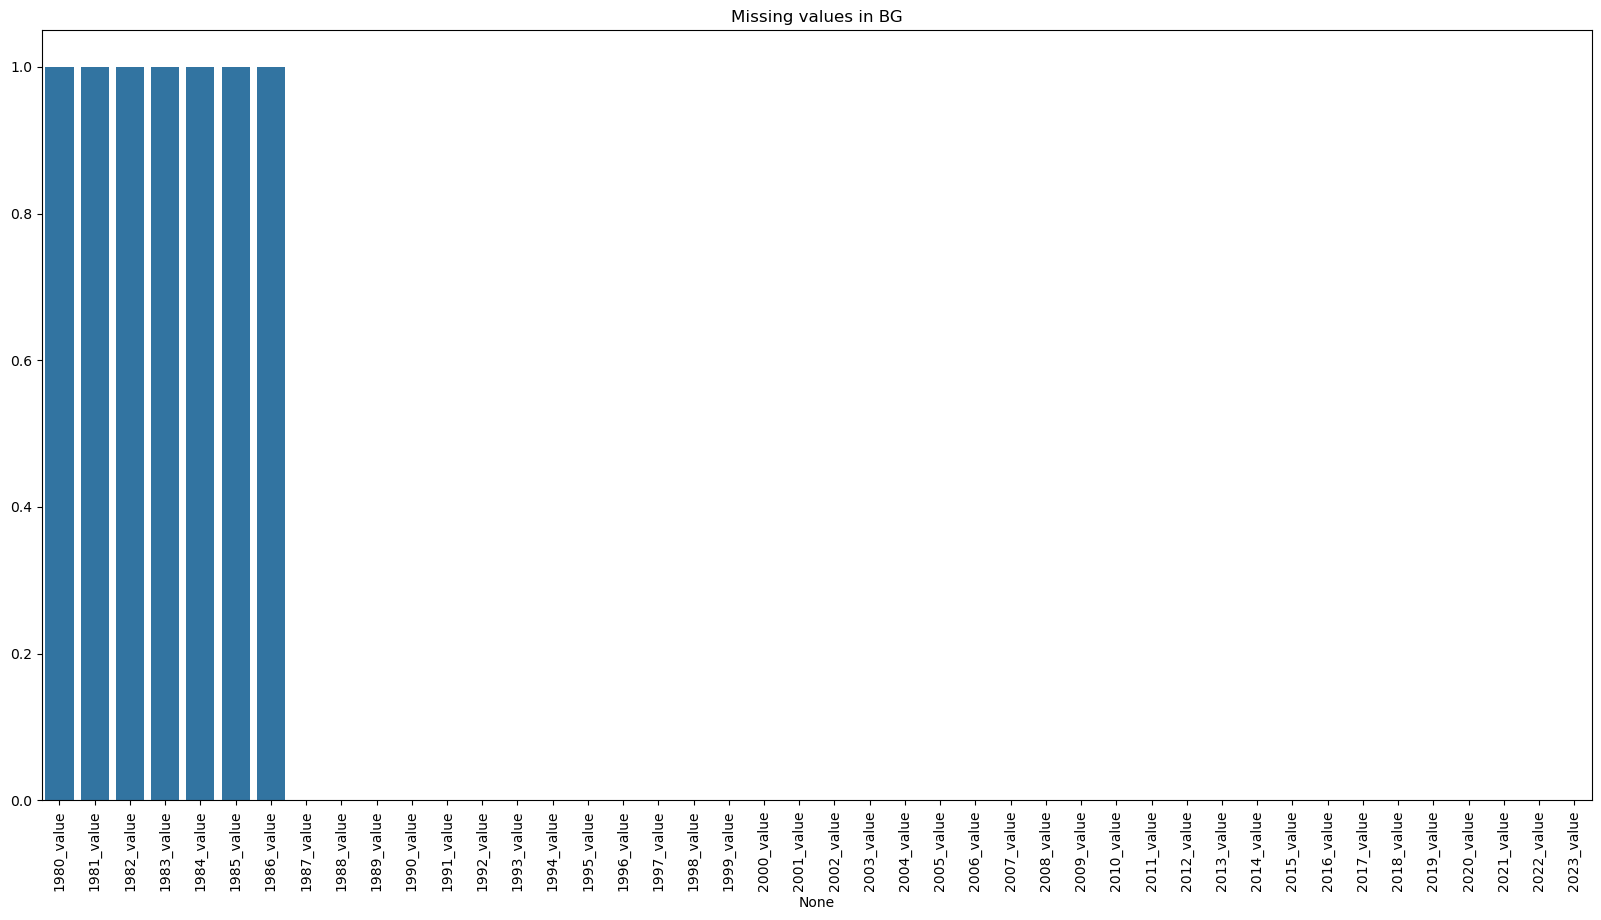

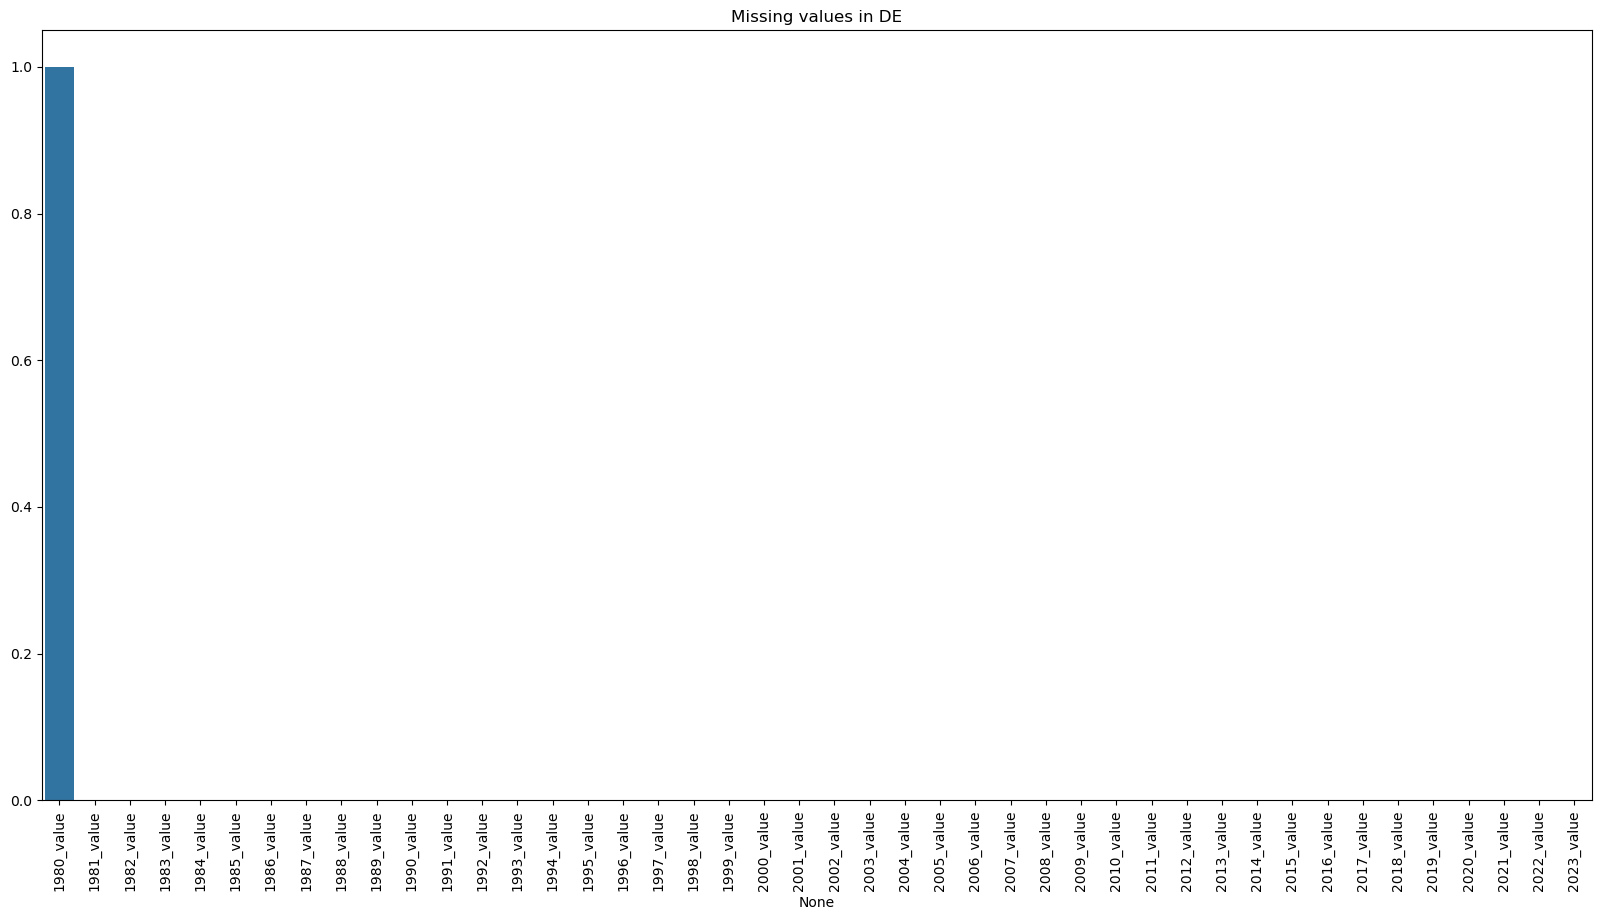

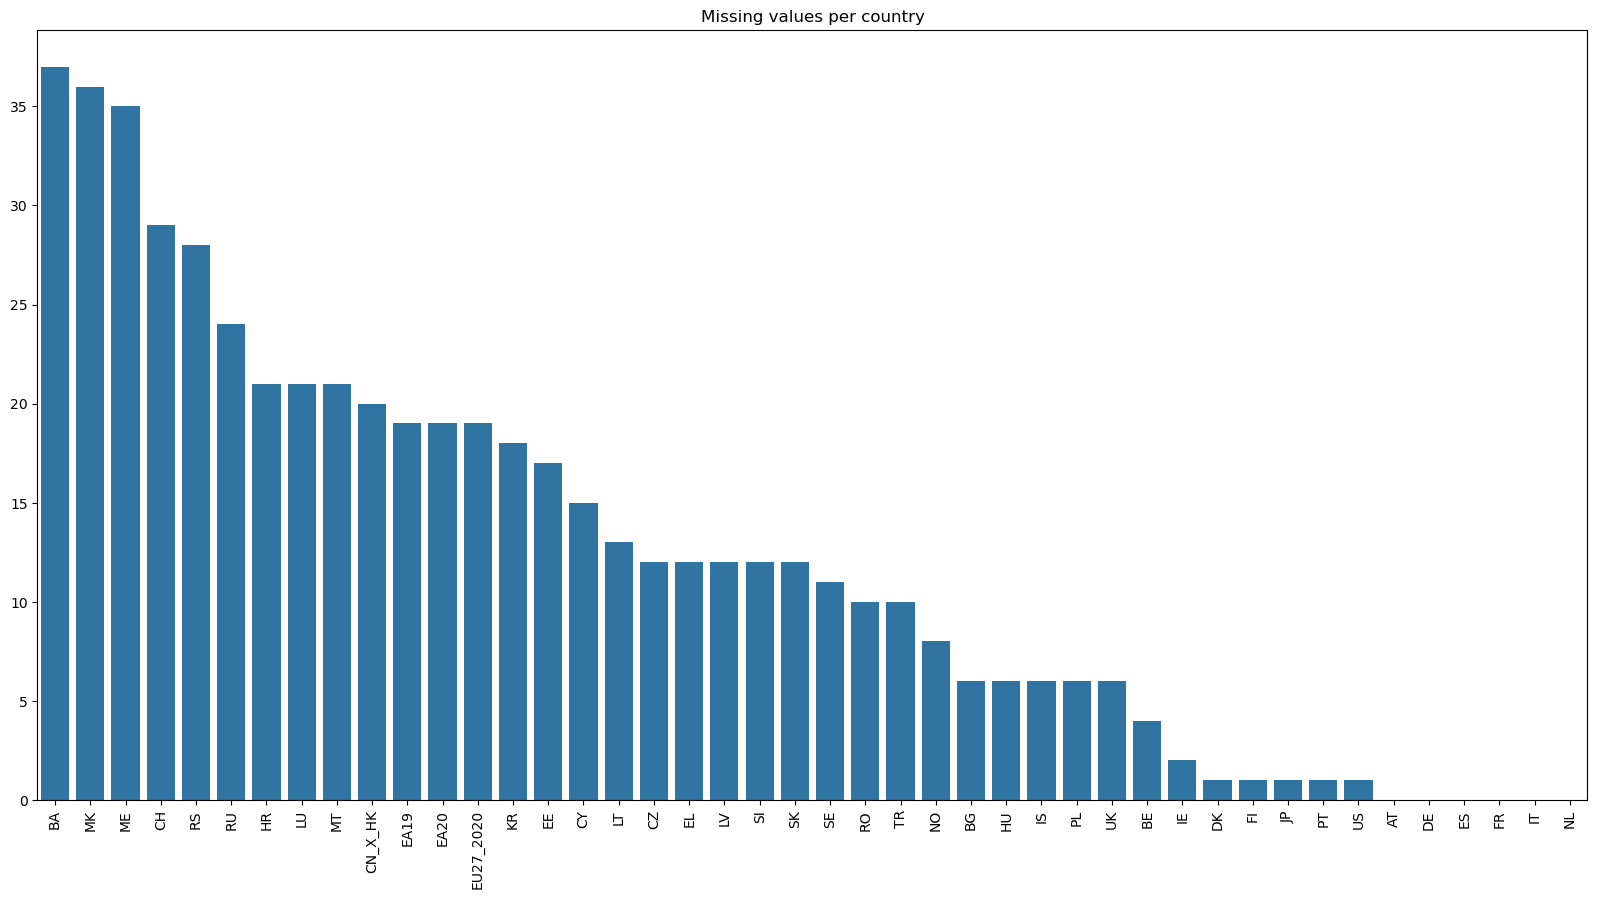

In [48]:
time_span = 43 # max timespan =43 current year - time_span
sector = "TOTAL" # All sectors
unit = "EUR_HAB" # Euro per inhabitant
# access the data this can be accessed like [-2*time_span:] but the first 4 columns should also be kepped since they have valueable information
import seaborn as sns
import matplotlib.pyplot as plt

dataBySector = RD_EXP_BY_SECTOR[(RD_EXP_BY_SECTOR["sectperf"] == sector) & (RD_EXP_BY_SECTOR["unit"] == unit)]
missingData = {}
# check for missing values per country

def getMissingDataForTimespan(dataBySector,time_span,plotCountries):
    missingData = {}
    for country in countries:
        country_data = dataBySector[dataBySector["geo\TIME_PERIOD"] == country]
        missing_values = country_data.isnull().sum()
        missing_values = missing_values[missing_values.index.str.contains(r'\d{4}_value')]
        missingData[country] = sum(missing_values[-time_span:])
        if country in plotCountries:
            plt.figure(figsize=(20,10))
            sns.barplot(x=missing_values.index,y=missing_values.values)
            plt.xticks(rotation=90)
            plt.title("Missing values in "+country)
            plt.show()
    return missingData

missingData = getMissingDataForTimespan(dataBySector,time_span,["DE","BG"])
# plot the distribution of missing values per country
#sort the values by the number of missing values
missingData = dict(sorted(missingData.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(20,10))
sns.barplot(x=missingData.keys(),y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country")
plt.show()

    

Find the timespan where got the most data to support the analysis.

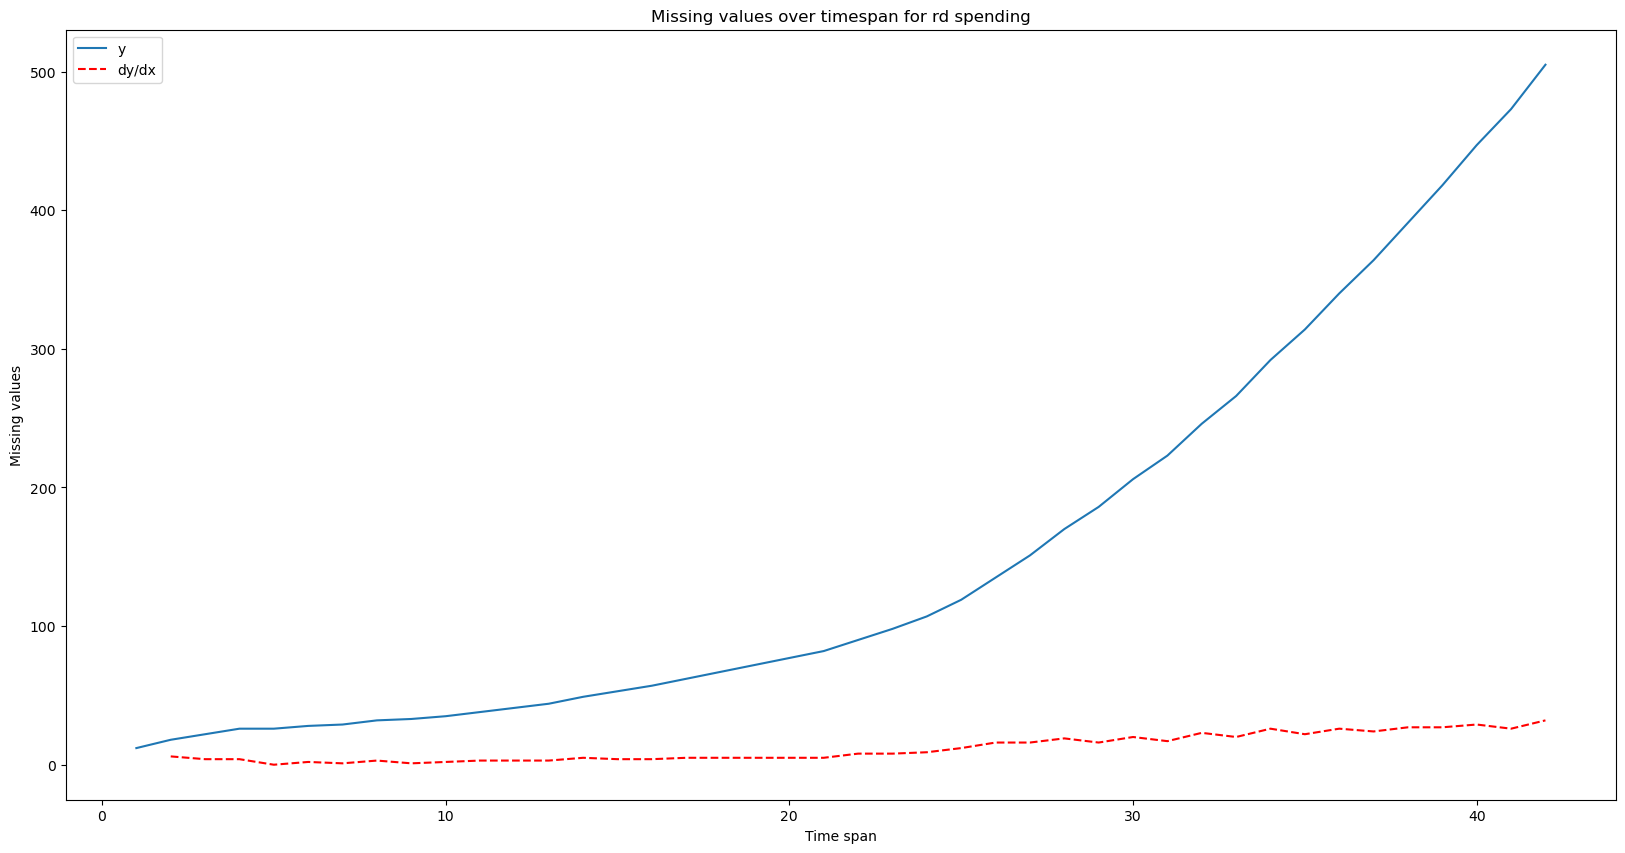

In [51]:
import pandas as pd
plotData = pd.DataFrame()
#add columns x and y
plotData["x"] = range(1, 43)
plotData["y"] = [sum(getMissingDataForTimespan(dataBySector, time_span, []).values()) for time_span in range(1, 43)]

# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()

# Plotting the data and its derivative
plt.figure(figsize=(20, 10))

# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")

# Plot the derivative
sns.lineplot(data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red")
plt.xlabel("Time span")
plt.ylabel("Missing values")
plt.title("Missing values over timespan for rd spending")
plt.legend()
plt.show()
    

Looks like for a time span sub 20-30 years, the data has not too many missing values. Also the number of missing values starts to increase after a time span of ca 23 years.

Do the same for the patent dataset, and see if the same pattern is observed.

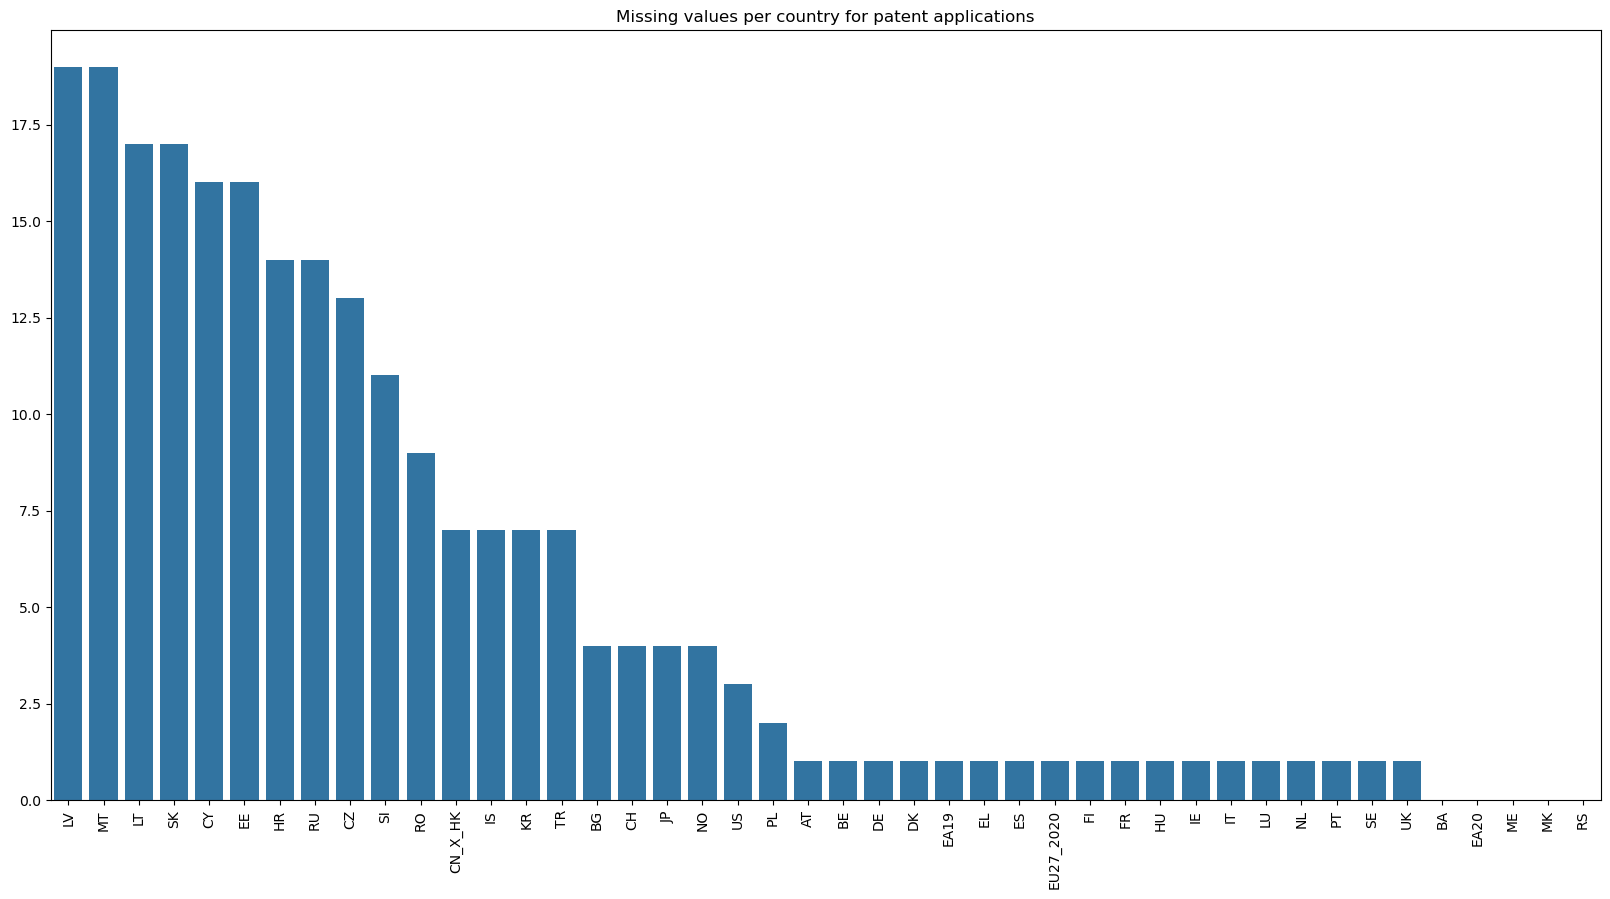

In [43]:
time_span = 43
unit = "NR" #should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS[(PAT_APPLICATIONS["unit"] == unit)]

missingData = getMissingDataForTimespan(data,time_span,[])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(20,10))
sns.barplot(x=missingData.keys(),y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()


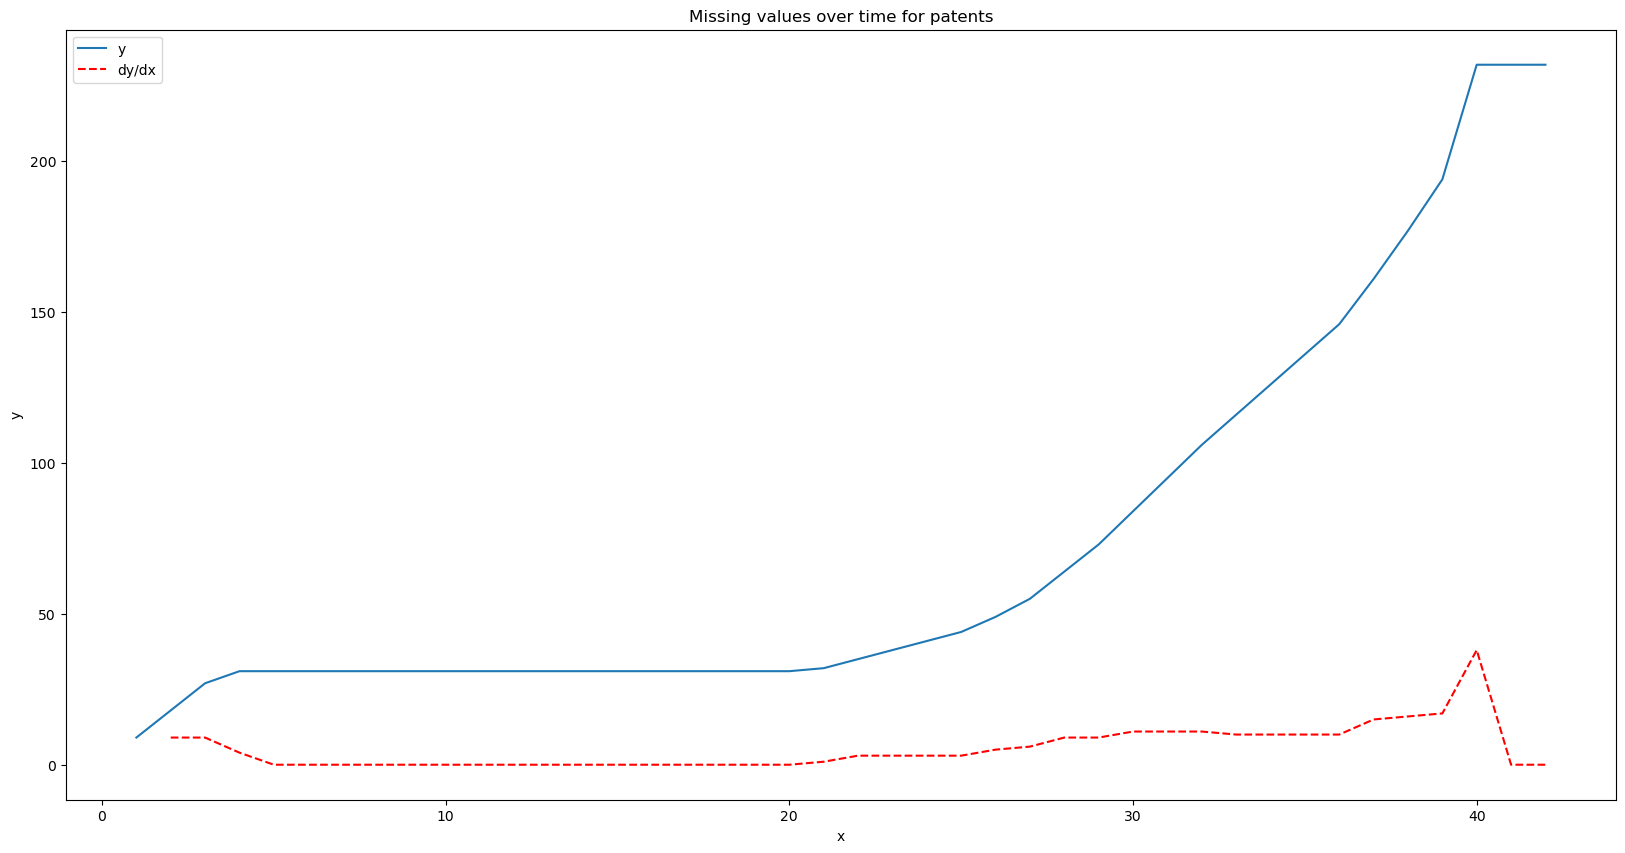

In [45]:
import pandas as pd
plotData = pd.DataFrame()
#add columns x and y
plotData["x"] = range(1, 43)
plotData["y"] = [sum(getMissingDataForTimespan(data, time_span, []).values()) for time_span in range(1, 43)]

# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()

# Plotting the data and its derivative
plt.figure(figsize=(20, 10))

# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")

# Plot the derivative
sns.lineplot(data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red")
plt.title("Missing values over time for patents")
plt.legend()
plt.show()

Looks like the patent dataset as good data for the last 20-25 years.

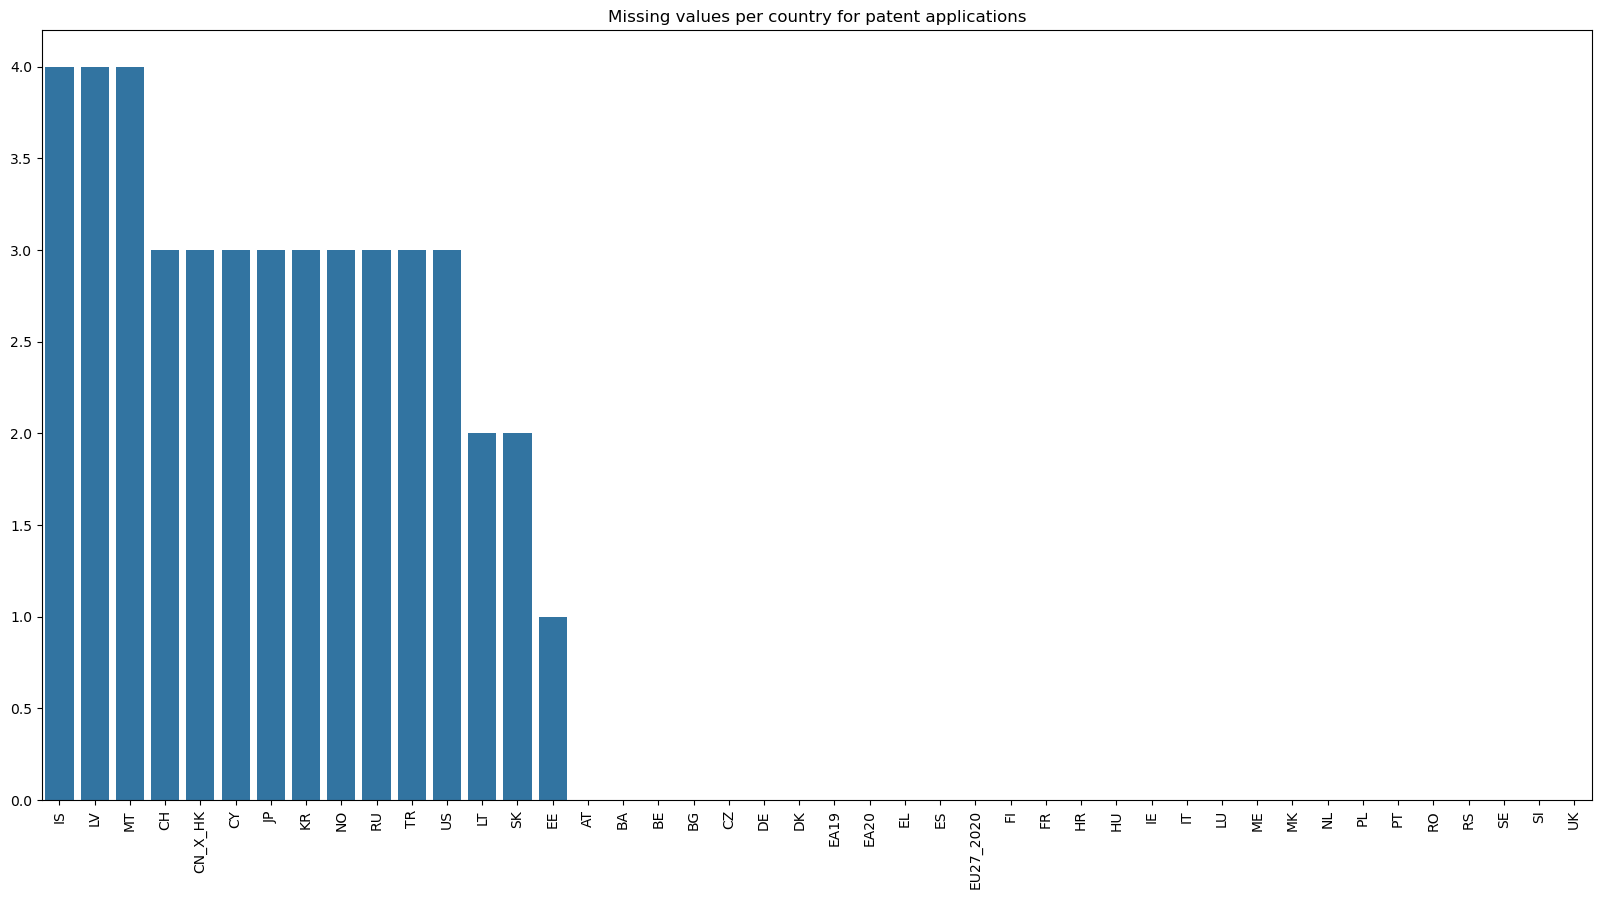

In [47]:
time_span = 25
unit = "NR" #should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS[(PAT_APPLICATIONS["unit"] == unit)]

missingData = getMissingDataForTimespan(data,time_span,[])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(20,10))
sns.barplot(x=missingData.keys(),y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()